In [18]:
#%reset -f

import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from print_array import *
import time
import scipy.optimize as opt

In [9]:

class instrument:
    xmin=0; xmax=100; ymin=0; ymax=100 #boundaries for search
  
    def __init__(self,motorspeed,error,starttime):#s/steps,error for 1s integration time
        self.motorspeed=motorspeed
        self.error=error
        self.starttime=starttime
        self.t=0
        self.pos=np.array([self.xmin+np.random.uniform(0,self.xmax-self.xmin),self.ymin+np.random.uniform(0,self.ymax-self.ymin)])#random position
        self.x1=np.random.uniform(1,90)
        self.x2=np.random.uniform(1,90)
        self.sig1=np.random.uniform(5.0,10.0)
        self.sig2=np.random.uniform(5.0,10.0)
        self.theta=np.random.uniform(0,2*np.pi)
        self.func=lambda x: np.exp(-0.5*((((x[0]-self.x1)*np.cos(self.theta)-(x[1]-self.x2)*np.sin(self.theta))/self.sig1)**2+(((x[0]-self.x1)*np.sin(self.theta)+(x[1]-self.x2)*np.cos(self.theta))/self.sig2)**2))
 
    def scan(self,x,st):#position, scan time
        self.t+=(abs(x[0]-self.pos[0])+abs(x[1]-self.pos[1]))*self.motorspeed+st+self.starttime
        self.pos=np.array(x)
        return self.func(x)+np.random.normal(0,self.error,(1))[0]*(0.1+0.9*st**-.5)
    

#MIM_LP_DOAS=instrument(50,0.01,0.5)
#print('measurement value at [20,30] for a integaration time of 10s:',MIM_LP_DOAS.scan([20,30],10))


In [3]:
def calc_std(n, st):
    instr_std = instrument(1,.05,0)
    measure = np.zeros(n)
    for i in range(n):
        measure[i] = instr_std.scan([20,30], st)
    std = measure.std()
    return std

In [3]:
scantimes = np.arange(1,100,1)
stds = np.zeros(len(scantimes))
for i in scantimes:
    stds[i-1] = calc_std(100,i)
    
#fit the following function f(t) = c1 + c2/sqrt(t)

fit_func = lambda t, c1, c2 : c1 + c2 / np.sqrt(t)
opt_param, opt_cov = opt.curve_fit(fit_func, scantimes, stds)

NameError: name 'calc_std' is not defined

**Better Search Algorithm**

In [10]:
def construct_coords(center, step):
    
    #working our way towards the maximum in two circles with 1*step and 2*step distance to the center:
    # inner circle: 8 points
    # outer circle: 16 points
        
    compare_coord = np.array(((0,1),\
                              (np.sqrt(0.5),np.sqrt(0.5)),\
                              (1,0),\
                              (np.sqrt(0.5),-np.sqrt(0.5)),\
                              (0,-1),\
                              (-np.sqrt(0.5),-np.sqrt(0.5)),\
                              (-1,0),\
                              (-np.sqrt(0.5),np.sqrt(0.5)),\
                              (0,2),\
                              (-1*np.sqrt(4/1.25)/2,2*np.sqrt(4/1.25)/2),\
                              (-2*np.sqrt(0.5),2*np.sqrt(0.5)),\
                              (-2*np.sqrt(4/1.25)/2,1*np.sqrt(4/1.25)/2),\
                              (-2,0),\
                              (-2*np.sqrt(4/1.25)/2,-1*np.sqrt(4/1.25)/2),\
                              (-2*np.sqrt(0.5),-2*np.sqrt(0.5)),\
                              (-1*np.sqrt(4/1.25)/2,-2*np.sqrt(4/1.25)/2),\
                              (0,-2),\
                              (1*np.sqrt(4/1.25)/2,-2*np.sqrt(4/1.25)/2),\
                              (2*np.sqrt(0.5),-2*np.sqrt(0.5)),\
                              (2*np.sqrt(4/1.25)/2,-1*np.sqrt(4/1.25)/2),\
                              (2,0),\
                              (2*np.sqrt(4/1.25)/2,1*np.sqrt(4/1.25)/2),\
                              (2*np.sqrt(0.5),2*np.sqrt(0.5)),\
                              (1*np.sqrt(4/1.25)/2,2*np.sqrt(4/1.25)/2)))

    
    coords = np.full((len(compare_coord)+1,2), center)
    
    coords[1:,:] = coords[1:,:] + compare_coord[:,:]*step
            
    return coords

In [11]:
def line_search(inst, scantime, xmin, xmax, ymin, ymax, ac, nsteps, pl = False):
    
    found = False
    max_row = 0.0
    max_row_i = 404
    max_column = 0.0
    max_column_i = 404
    step = int((xmax-xmin)/nsteps)
    
    scan_grid = np.zeros((int((xmax-xmin)/ac), int((ymax-ymin)/ac)))
    
    for i in np.linspace(xmin, xmax, nsteps, endpoint = False):
        i = int(i)
        for j in np.linspace(ymin, ymax, nsteps, endpoint = False):
            j = int(j)
            scan_grid[i,j] = inst.scan([i,j], scantime)
            scan_grid[j,i] = inst.scan([j,i], scantime)
        if(np.sum(scan_grid[i,:]) > max_row): 
            max_row = np.sum(scan_grid[i,:])
            max_row_i = i
        if(np.sum(scan_grid[:,i]) > max_column): 
            max_column = np.sum(scan_grid[:,i])
            max_column_i = i
        if(pl == True):
            for k in np.arange(scan_grid.shape[0]): 
                plt.scatter(i, int(k), color = 'k', marker = 'x')
                plt.scatter(int(k), i, color = 'k', marker = 'x')
    
    return (max_row_i, max_column_i), scan_grid[max_row_i, max_column_i]

In [17]:
t1 = time.time()

instr_search = None

instr_search = instrument(50,0.01,0.5)

xmin = instr_search.xmin
xmax = instr_search.xmax
ymin = instr_search.ymin
ymax = instr_search.ymax

acc = 1.0
scantime = 1

plot = False

if(plot == True):
    
    n_x = (xmax-xmin)/acc
    n_y = (ymax-ymin)/acc

    scan_grid = np.zeros((int(n_x),int(n_y)))
    
    for i in np.arange(n_x):
        for j in np.arange(n_y):
            scan_grid[int(i),int(j)] = instr_search.scan([int(xmin+acc*i),int(ymin+acc*j)], scantime)
            
    fig, ax = plt.subplots(figsize = (8,8))
    col_bar = plt.imshow(scan_grid.T[::-1,:], interpolation = 'nearest',cmap='jet_r', extent=[xmin,xmax,ymin,ymax])

number_steps = 10
step_initial = xmax / number_steps
step = step_initial
max_value = 0

scantime = 1

while(max_value < 0.7 and number_steps > 2):

    center_initial, new_max_value = line_search(instr_search, scantime, xmin, xmax, ymin, ymax, acc, number_steps, plot)
    if(new_max_value > max_value): max_value = new_max_value
    if(plot == True): plt.scatter(center_initial[0],center_initial[1],marker = 'x', color = 'orange', linewidth = 50)
    number_steps = int(number_steps/2)

center = center_initial

scantime = 100
step = 5
search = True
rep = 0
cycle = 0

while(search == True):
    
    cycle = cycle + 1
    
    coords = construct_coords(center, step)
    
    for i in coords:
        
        new_max_value = instr_search.scan([i[0],i[1]], scantime)
        
        if(plot == True): plt.scatter(i[0],i[1], color = 'k')
        
        if(new_max_value > max_value):
            max_value = new_max_value
            coord_max = int(i[0]),int(i[1])
    
    #plt.scatter(coord_max[0],coord_max[1], c = max_value, cmap = 'jet')
    
    if(max_value > 0.99 or cycle > 100): 
        rep = rep + 1
        step = step - 1
        if(rep == 4): 
            search = False
            if (plot == True): plt.scatter(coord_max[0], coord_max[1],marker = 'x', color = 'g', linewidth = 50)
        
    center = coord_max

print('Maximum of ' + str(max_value) + ' found at: ' + str(coord_max))
if(plot == True):
    fig.colorbar(col_bar)
    plt.show()
    
t2 = time.time()
print('Time taken: %f', t2-t1)
print('Instrument time: %f.2 in hours', instr_search.t/3600)

Maximum of 0.9952777079575734 found at: (64, 33)
Time taken: %f 0.12100481986999512
Instrument time: %f.2 in hours 449.5036126589629


**Additional Stuff**

In [ ]:
scantimes = np.arange(1,100,1)
stds = np.zeros(len(scantimes))
for i in scantimes:
    stds[i-1] = calc_std(100,i)
    
#fit the following function f(t) = c1 + c2/sqrt(t)

fit_func = lambda t, c1, c2 : c1 + c2 / np.sqrt(t)
opt_param, opt_cov = opt.curve_fit(fit_func, scantimes, stds)

plt.figure(figsize=(8,8))
plt.plot(scantimes, stds, label = 'standard deviation')
plt.plot(scantimes, fit_func(scantimes, opt_param[0], opt_param[1]), label = 'fitted curve') 
plt.ylabel('standard deviation')
plt.xlabel('scantime in secs')
plt.show()

print('C1 = ' + str(opt_param[0]) + '\tC2 = ' + str(opt_param[1]))

time needed for search: 0.07801032066345215
maximum of1.1213969174357619found atmaxxpos	maxypos
best scantime: [0.01]	best stepsize: 1


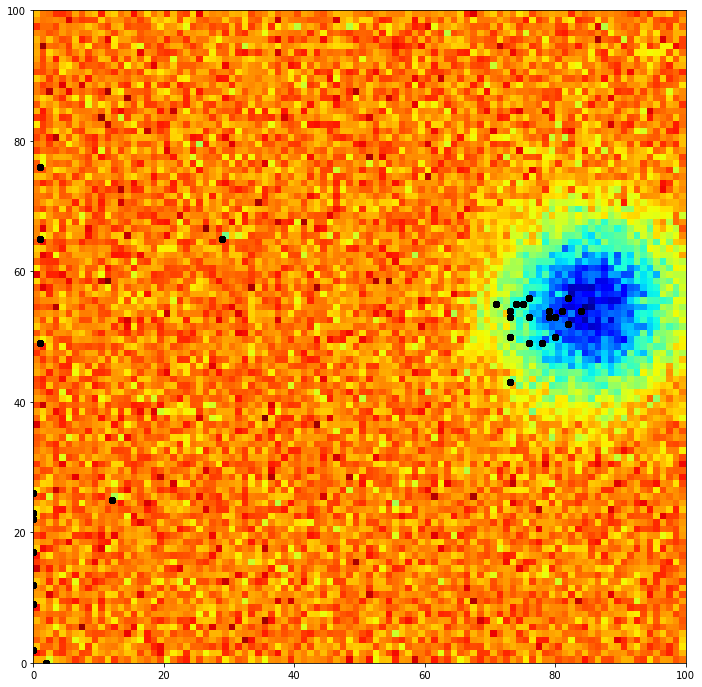

Time taken:  3.6925747394561768


In [14]:
time1 = time.time()

instr = instrument(50,0.01,0.5)

acc = 1.0
scantime = np.arange(0.01,1,99) 
stepsize = np.arange(1,10,1)

show = True

nx = (instr.xmax-instr.xmin)/acc
ny = (instr.ymax-instr.ymin)/acc

func_grid = np.zeros((int(nx),int(ny)))

for i in np.arange(nx): 
    for j in np.arange(ny):
        func_grid[int(i),int(j)] = instr.scan([int(instr.xmin+acc*i),int(instr.ymin+acc*j)], scantime)

fig, axs = plt.subplots(1,1,figsize=(12,12))
 
searchtime = 100
    
for k in scantime:
    for l in stepsize:
        t0 = time.time()

        maxxpos = int(instr.xmin);
        maxypos = int(instr.ymin);

        err = 0.05

        for i in np.arange(instr.xmin,instr.xmax,acc):
            for j in np.arange(instr.ymin,instr.ymax,acc):
                if (func_grid[int(i),int(j)]>func_grid[maxxpos,maxypos]):
                    maxxpos=int(i);
                    maxypos=int(j);
                    maxval = func_grid[maxxpos,maxypos];
                    if show:
                        plt.scatter(maxxpos,maxypos,color='black')

        t1 = time.time()
        
        if(t1-t0 < searchtime): 
            searchtime = t1-t0
            best_scantime = k
            best_stepsize = l

print('time needed for search: ' + str(searchtime))
print('maximum of' + str(maxval) + 'found at' + 'maxxpos\t' + 'maxypos')
print('best scantime: ' + str(scantime) + '\tbest stepsize: ' + str(best_stepsize))

if show:
    plt.imshow(func_grid.T[::-1,:], interpolation = 'nearest',cmap='jet_r', extent=[instr.xmin,instr.xmax,instr.ymin,instr.ymax])
    plt.show()

time2 = time.time()

print('Time taken: \f', time2-time1)